# Imports 

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import sys
from multiprocessing import Pool, RawArray
from scipy.spatial import distance
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from tracking import contiguous_regions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [182]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording

# -----------------------#




# set datapaths for saving later on
clusterable_data_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'fight_detection_data/clusterable_data.h5')
clusterable_data_dmat_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'fight_detection_data/clusterable_data_dmat.h5')
clusterable_data_labels_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'fight_detection_data/clusterable_data_labels.h5')
cluster_params_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'fight_detection_data/cluster_params.h5')
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# get the filepaths of the traking results
loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    

other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


# Compute $\theta_{W}$, $\theta_{L}$ and $D_{PP}$ for all experiments

In [4]:
interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording

In [5]:
t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []
exp_numFrames = []


for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    exp_numFrames.append(smooth_traj.shape[0])
    
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538
FishTank20200129_140656
FishTank20200130_153857
FishTank20200130_181614
FishTank20200207_161445
FishTank20200213_154940
FishTank20200214_153519
FishTank20200217_160052
FishTank20200218_153008
FishTank20200316_163320
FishTank20200327_154737
FishTank20200330_161100
FishTank20200331_162136
FishTank20200520_152810
FishTank20200521_154541
FishTank20200525_161602
FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740
FishTank20200828_155504
FishTank20200902_160124
FishTank20200903_160946

finished: 7.394581590080634 s


# Functions

In [6]:
def map_02Pi_array_to_minusPiPi_array(arr):
    ''' Given a timeseries of angles in the range (0, 2pi),
        return the same timeseries in the range (-pi, pi)
    '''
    out_arr = np.copy(arr)
    too_big_idxs = np.where(arr > np.pi)[0]
    too_neg_idxs = np.where(arr < -np.pi)[0]
    out_arr[too_big_idxs] -= 2*np.pi
    out_arr[too_neg_idxs] += 2*np.pi
    return out_arr

def sum_theta_angles(tet1, tet2):
    ''' Add the two arrays of theta angles, keeping the (-pi,pi) range.
    
    -- args --
    tet1: arr shape (numFrames,)
    tet2: arr shape (numFrames,)
    
    -- returns --
    sum_thetas: arr shape (numFrames)
    '''
    # map to (0,2pi) range
    alpha1 = tet1 + np.pi
    alpha2 = tet2 + np.pi
    # sum
    alpha = alpha1 + alpha2
    #  apply boundary
    beta = np.mod(alpha, 2*np.pi)
    # map back to -pi, pi
    sum_thetas = map_02Pi_array_to_minusPiPi_array(beta)
    return sum_thetas

def abs_diff_theta_angles(tet1, tet2):
    ''' Subtract the two arrays of theta angles, keeping the (-pi,pi) range,
        then take the absolute value.
    
    -- args --
    tet1: arr shape (numFrames,)
    tet2: arr shape (numFrames,)
    
    -- returns --
    abs_diff_thetas: arr shape (numFrames)
    '''
    # map to (0,2pi) range
    alpha1 = tet1 + np.pi
    alpha2 = tet2 + np.pi
    alpha = alpha1 - alpha2
    # sum and apply boundary
    beta = np.mod(alpha, 2*np.pi)
    # map back to -pi, pi, then take the absolute value
    abs_diff_thetas = np.abs(map_02Pi_array_to_minusPiPi_array(beta))
    return abs_diff_thetas

def diff_theta_angles(tet1, tet2):
    ''' Subtract the two arrays of theta angles, keeping the (-pi,pi) range,
    
    -- args --
    tet1: arr shape (numFrames,)
    tet2: arr shape (numFrames,)
    
    -- returns --
    diff_thetas: arr shape (numFrames)
    '''
    # map to (0,2pi) range
    alpha1 = tet1 + np.pi
    alpha2 = tet2 + np.pi
    alpha = alpha1 - alpha2
    # sum and apply boundary,
    beta = np.mod(alpha, 2*np.pi)
    # map back to -pi, pi
    diff_thetas = map_02Pi_array_to_minusPiPi_array(beta)
    return diff_thetas


def symmetrize_tet1_tet2(tet1, tet2):
    ''' Use a symmetric function to transform tet1 into tet2 into variables
        where the order of tet1 and tet2 doesn't matter.
    
    -- args --
    tet1: arr shape (numFrames,)
    tet2: arr shape (numFrames,)
    
    -- returns --
    sum_thetas: arr shape (numFrames)
    '''
    tet1_plus_tet2 =  sum_theta_angles(tet1, tet2)
    abs_tet1_minus_tet2 =  abs_diff_theta_angles(tet1, tet2)
    return tet1_plus_tet2, abs_tet1_minus_tet2

In [7]:
def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)


def get_1D_prob_vectors_from_dpp_g1_g2_in_timeWins(dpp, g1, g2, dppBins, g1Bins, g2Bins, timeWins):
    ''' Return the 1D probability vector from the 3D histogramming of (dpp,g1,g2),
        using the spatial bins provided, and the timeWins provided. timeWins may be a decimated
        time_windows array.
        
    These 1D probability vectors represenent the probability of being in each of the microstates
    defined by the spatial binning, in that particular window of time. 
        
    --- args ---
    dpp: (numFrames,)
    g1: (numFrames,)
    g2: (numFrames,)
    dppBins: (numBins,)
    g1Bins: (numBins,)
    g2Bins: (numBins,)
    timeWins: (numWindows, win_start_and_stop)

    --- returns ---
    prob_vectors_for_wins: (numWindows, num_dpp_bins*num_g1_bins*num_g2_bins),
                            
    '''
    # parse info
    hist_bins = [dppBins, g1Bins, g2Bins]
    numFrames = dpp.shape[0]
    if ~ dpp.shape[0] == g1.shape[0] == g2.shape[0]:
        raise TypeError('dpp, g1, g2 are not the same length')
    numWindows = timeWins.shape[0]
    
    # --------- get the prob vectors for all windows ------ #
    probs = []
    for winIdx in range(numWindows):
        # parse the data for this windows
        f0,fE = timeWins[winIdx]
        # grab the data
        win_g1 = g1[f0:fE]
        win_g2 = g2[f0:fE]
        win_dpp = dpp[f0:fE]
        # Make (N,D) data
        win_data = np.stack([win_dpp, win_g1, win_g2], axis=1)
        # get the probs
        hist_counts, hist_edges = np.histogramdd(win_data, bins=hist_bins, density=True)
        hist_probs = hist_counts / np.sum(hist_counts)
        probs.append(hist_probs)
    # convert probs list to array
    prob_vectors_for_wins = np.array(probs)
    # cast dpp-theta-theta dist into 1D form (first dim runs along windows)
    prob_vectors_for_wins = prob_vectors_for_wins.reshape(prob_vectors_for_wins.shape[0], -1)
    return prob_vectors_for_wins

# Prepare the data to cluster

In [8]:
# ----------- bins --------------#
# designed to match the infomap results (main paper figure data)
dpp_bins = np.arange(0, 20+1, 1)              # the bin-edges array for the binning of Dpp
theta_bins = np.linspace(-np.pi, np.pi, 20+1)         # the bin-edges array for the binning of Tet1 and Tet2
g1_bins = np.linspace(-np.pi, np.pi, 20+1)         # the bin-edges array for g1
g2_bins = np.linspace(0, np.pi, 20+1)         # the bin-edges array for g2
window_size = 6000                            # the size of the windows in frames
window_step = 100                             # the number of frames between centers of neighbouring windows
skip_size = 30                                # the number of windows to skip between samples when gathering clustering data

numStates = (dpp_bins.shape[0]-1)*(theta_bins.shape[0]-1)*(theta_bins.shape[0]-1)

cluster_params = {'dpp_bins':dpp_bins,
                  'theta_bins':theta_bins,
                  'numStates':numStates,
                  'window_size':window_size,
                  'window_step':window_step,
                  'skip_size':skip_size,
                  'g1_bins':g1_bins,
                  'g2_bins':g2_bins}

In [9]:
t0 = time.perf_counter()


exps_decimated_prob_vecs_list = []
exps_decimated_timeWins_list = []
exp_g1s = []
exp_g2s = []

for expIdx, expName in enumerate(expNames):
    
    # ---- time windows ---#
    numFrames = exp_numFrames[expIdx]
    time_windows = return_overlapping_windows_for_timeframes(numFrames, 
                                                             window_size=cluster_params['window_size'], 
                                                             window_step=cluster_params['window_step'])
    # and decimated time windows
    decimated_exp_time_windows = time_windows[::cluster_params['skip_size'], :]
    
    
    # --- get Dpp,tet1,tet2 --- #
    dpp = exp_dpps[expIdx]
    tet1 = exp_tetWs[expIdx]
    tet2 = exp_tetLs[expIdx]
    
    
    # ---- compute the transformed variables ---- #
    g1_arr, g2_arr = symmetrize_tet1_tet2(tet1, tet2)
    
    # --------- get the prob vectors for the decimated time_windows ------ #
    prob_vectors_for_decimated_wins = get_1D_prob_vectors_from_dpp_g1_g2_in_timeWins(dpp, g1_arr, g2_arr,
                                                                                    cluster_params['dpp_bins'],
                                                                                    cluster_params['g1_bins'],
                                                                                    cluster_params['g2_bins'],
                                                                                    decimated_exp_time_windows)
    
    # ------ select only distributions without any NaNs -------#
    # apply the mask for the probvecs to the time_windows too, to keep track of which we use
    prob_vectors_for_decimated_wins_nanless = prob_vectors_for_decimated_wins[ np.where(~np.isnan(prob_vectors_for_decimated_wins).any(axis=1))[0] ]
    decimated_exp_time_windows_nanless = decimated_exp_time_windows[ np.where(~np.isnan(prob_vectors_for_decimated_wins).any(axis=1))[0] ]
    
    
    # ----------------------- record -----------------------#
    exps_decimated_prob_vecs_list.append(prob_vectors_for_decimated_wins_nanless)
    exps_decimated_timeWins_list.append(decimated_exp_time_windows_nanless)
    exp_g1s.append(g1_arr)
    exp_g2s.append(g2_arr)
    
    
    # ------- finish up ----------
    print(expName, ' finished: ', time.perf_counter()-t0)
       
print()
print(time.perf_counter() - t0, ' s')
    

/tmp/ipykernel_884602/3243086601.py:28: RuntimeWarning: invalid value encountered in remainder
  beta = np.mod(alpha, 2*np.pi)
/tmp/ipykernel_884602/3243086601.py:49: RuntimeWarning: invalid value encountered in remainder
  beta = np.mod(alpha, 2*np.pi)


FishTank20200127_143538  finished:  0.2942708469927311
FishTank20200129_140656  finished:  0.5091853770427406
FishTank20200130_153857  finished:  0.6477822801098228
FishTank20200130_181614  finished:  0.7928366891574115
FishTank20200207_161445  finished:  0.9132156970445067
FishTank20200213_154940  finished:  1.1162953041493893
FishTank20200214_153519  finished:  1.2442481860052794
FishTank20200217_160052  finished:  1.4078171860892326
FishTank20200218_153008  finished:  1.5495364831294864
FishTank20200316_163320  finished:  1.8366514299996197
FishTank20200327_154737  finished:  1.9843017931561917
FishTank20200330_161100  finished:  2.129891452146694
FishTank20200331_162136  finished:  2.337150804931298
FishTank20200520_152810  finished:  2.690365373156965
FishTank20200521_154541  finished:  2.843562499154359
FishTank20200525_161602  finished:  2.997992452001199
FishTank20200526_160100  finished:  3.183082499075681
FishTank20200527_152401  finished:  3.3129432550631464
FishTank20200824

/home/liam/anaconda3/envs/analysis/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


FishTank20200903_160946  finished:  4.399592877132818

4.400091334013268  s


In [10]:
# ------- Combine results from various experiments --------- #

# combine the distributions
prob_vectors_clusterable_data = np.concatenate(exps_decimated_prob_vecs_list, axis=0)

# to combine the time arrays, add in the expIdx
expidx_and_decimated_wins_clusterable_data = []
for expIdx, expName in enumerate(expNames):
    exp_decimated_wins = exps_decimated_timeWins_list[expIdx]
    # preallocate an array the same size, but with 3 cols instead of two
    expidx_and_decimated_wins = np.zeros((exp_decimated_wins.shape[0], 3), dtype=int)
    # fill-in the expIdx in the first column, and the timewindows in the other two
    expidx_and_decimated_wins[:,0] = expIdx
    expidx_and_decimated_wins[:,1:] = exp_decimated_wins
    # record
    expidx_and_decimated_wins_clusterable_data.append(expidx_and_decimated_wins)
expidx_and_decimated_wins_clusterable_data = np.concatenate(expidx_and_decimated_wins_clusterable_data, axis=0)

In [11]:
prob_vectors_clusterable_data.shape

(5308, 8000)

In [12]:
expidx_and_decimated_wins_clusterable_data.shape

(5308, 3)

In [13]:
expidx_and_decimated_wins_clusterable_data

array([[     0,      0,   6000],
       [     0,   3000,   9000],
       [     0,   6000,  12000],
       ...,
       [    21, 711000, 717000],
       [    21, 714000, 720000],
       [    21, 717000, 723000]])

In [15]:
# --- save --- #
with h5py.File(clusterable_data_path, 'w') as hf:
    hf.create_dataset("prob_vectors_clusterable_data", data=prob_vectors_clusterable_data)
    hf.create_dataset("expidx_and_decimated_wins_clusterable_data", data=expidx_and_decimated_wins_clusterable_data)

# compute and save the distance matrix

In [16]:
# -----------------------------------------------------------------#
# ------ Cell for computing distance matrix in parallel ---------- #
# -----------------------------------------------------------------#
t0 = time.time()

# --- args --- #
numProcessors = 40

distribution_array = np.copy(prob_vectors_clusterable_data)

# --------------------------------------------------------------------------------------------#
# --------------------------------------------------------------------------------------------#

# make the list of distributions indices to map over
dist_idxs =  range(distribution_array.shape[0])

#  ---- make a shareable version of the theta probs --- #
# NB: this is a weird, necessary, formalisim for allowing multiple processes to share access to arrays
distribution_array_RARR = RawArray('d', int(np.prod(distribution_array.shape)))
distribution_array_np = np.frombuffer(distribution_array_RARR).reshape(distribution_array.shape)
np.copyto(distribution_array_np, distribution_array)


# A global dictionary storing the variables passed from the initializer
# This dictionary holds variables that each process will share access to, instead of making copies
var_dict = {}

# This function initializes the shared data in each job process
def init_worker(distribution_array, distribution_array_shape):
    var_dict['distribution_array'] = distribution_array
    var_dict['distribution_array_shape'] = distribution_array_shape
    
# define the function we will map over dist_idxs
def computing_jsd_function(i):
    ''' This is a function which is mapped over the individual distributions,
        to compute the jsd of each dist to all other dists.
    '''
    # get the numpy version of the distribution data
    distribution_array = np.frombuffer(var_dict['distribution_array']).reshape(var_dict['distribution_array_shape'])
    num_dists = distribution_array.shape[0]
    # preallocate the output
    focal_dist = distribution_array[i]
    jsd_array = np.zeros((num_dists,))
    for otherDistIdx in range(num_dists):
        other_dist = distribution_array[otherDistIdx]
        jsd_array[otherDistIdx] = distance.jensenshannon(focal_dist, other_dist, base=2)
    return jsd_array


# map the function
with Pool(processes=numProcessors, initializer=init_worker,
          initargs=(distribution_array_RARR, distribution_array.shape)) as pool:
    outputs = pool.map(computing_jsd_function, dist_idxs )
    
distance_matrix = np.array(outputs)


tE = time.time()
print(distance_matrix.shape)
print(tE-t0)

(5308, 5308)
247.100576877594


In [17]:
# --- save --- #
with h5py.File(clusterable_data_dmat_path, 'w') as hf:
    hf.create_dataset("dmat", data=distance_matrix)
    
print('saved')

saved


# load clusterable data and distance matrix

In [66]:

with h5py.File(clusterable_data_path, 'r') as hf:
    prob_vectors_clusterable_data = hf["prob_vectors_clusterable_data"][:]
    expidx_and_decimated_wins_clusterable_data = hf["expidx_and_decimated_wins_clusterable_data"][:]

In [67]:
prob_vectors_clusterable_data.shape

(5308, 8000)

In [68]:
expidx_and_decimated_wins_clusterable_data.shape

(5308, 3)

In [69]:

with h5py.File(clusterable_data_dmat_path, 'r') as hf:
    distance_matrix = hf["dmat"][:]

In [70]:
distance_matrix.shape

(5308, 5308)

# interpreting the clusters

In [51]:


dpp_bins = np.linspace(0, 20, 100)              # the bin-edges array for the binning of Dpp
theta_bins = np.linspace(-np.pi, np.pi, 100)    # the bin-edges array for the binning of Tet1 and Tet2
 
hist_bins = [dpp_bins, theta_bins, theta_bins]

In [52]:
#load clustering packages
import scipy.cluster as cl
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy



In [53]:
import scipy.cluster.hierarchy as sch
def seriation(Z,N,cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,Z=0,method="ward",precomputed=False):
    N = len(dist_mat)
    if precomputed:
        res_linkage = Z
    else:
        flat_dist_mat = ssd.squareform(dist_mat)
        res_linkage=sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

def symmetrize(a):
    return (a + a.T)/2 - np.diag(a.diagonal())

## ensure diagonality before ward's method

In [22]:


#this fixes possible numerical precision errors
sym_dissimilarity_matrix=symmetrize(distance_matrix)
sym_dissimilarity_matrix[sym_dissimilarity_matrix<0]=0

#turn distance matrix into a vector
pdist=ssd.squareform(sym_dissimilarity_matrix,force='tovector')

#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)



In [23]:
np.all(sym_dissimilarity_matrix == distance_matrix)

True

In [29]:
# if true, we don't need to do this

## Organize distance matrix according to the clustering

In [24]:
t0 = time.time()


#turn distance matrix into a vector
pdist=ssd.squareform(distance_matrix,force='tovector')
#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)

    
print(time.time()-t0)


0.8639683723449707


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
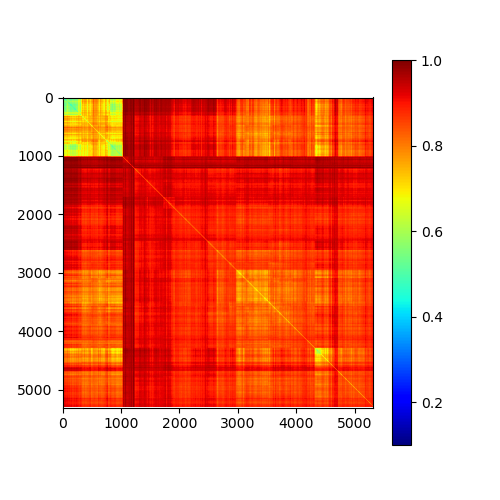

In [25]:
seriated_dist,res_order,res_linkage=compute_serial_matrix(distance_matrix,Z=Z,precomputed=True)
plt.figure(figsize=(5,5))
plt.title('')
plt.imshow(seriated_dist,cmap='jet',vmin=0.1)#,vmax=300)
plt.grid(False)
plt.colorbar()
plt.show()

## plot dendrogram and clusters, K=2

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
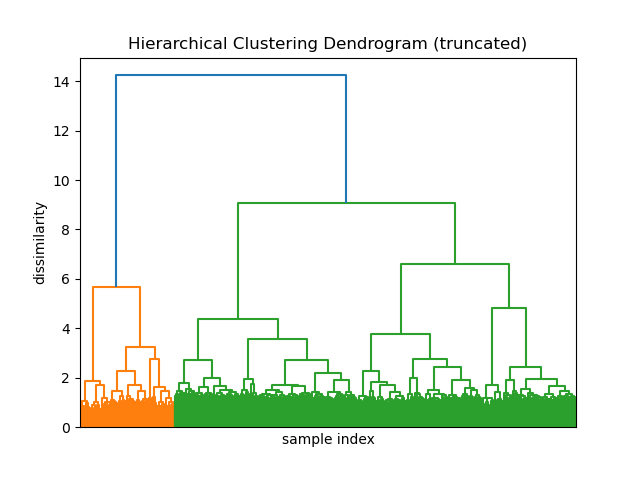

In [33]:


plt.figure()

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('dissimilarity')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    no_labels=True,
)
plt.grid(False)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
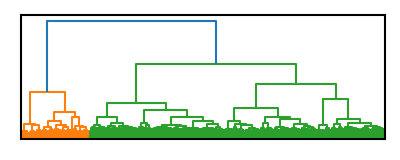

In [34]:


fig, ax = plt.subplots(figsize=(4,1.6))

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    no_labels=True,
    ax=ax,
)
ax.grid(False)

hierarchy.set_link_color_palette(['c', 'm', 'y', 'k'])


ax.set_yticks([]);

ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

fig.tight_layout()

#imsavepath = '/home/liam/temp/image_transfer/SI_fig_dend_k2_panelA.png'
#fig.savefig(imsavepath, transparent=True, dpi=300)


## paper figure - dendrogram (SI fig 6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
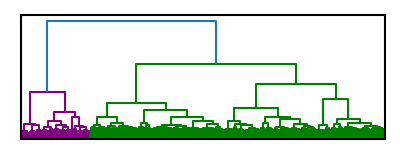

In [160]:


fig, ax = plt.subplots(figsize=(4,1.6))

hierarchy.set_link_color_palette(['purple', 'green'])

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    no_labels=True,
    ax=ax,
)
ax.grid(False)



ax.set_yticks([]);

ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
    
    
hierarchy.set_link_color_palette(None)  # reset to default after use

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig_dend_k2_panelA.png'
fig.savefig(imsavepath, transparent=True, dpi=300)

## interpreting the k=2 clusters

In [36]:
k=2 #fight/nonfight
cluster_labels = fcluster(Z, k, criterion='maxclust')


## ---- gather the data ---- ##


# list over cluster labels, where the empty list
cluster_data = [ [[],[],[]] for _ in range(k)]

# for each window, get the data
numWins = expidx_and_decimated_wins_clusterable_data.shape[0]
for winIdx in range(numWins):
    
    # parse info for this window
    win_expIdx,win_f0,win_fE = expidx_and_decimated_wins_clusterable_data[winIdx, :].astype(int)
    win_cls_idx = cluster_labels[winIdx] - 1  # to move from 1-indexing of cluster_labels to zero indexing
    
    # get the interpretation data for this windows
    win_dpp = exp_dpps[win_expIdx][win_f0:win_fE]
    win_theta_1 = exp_tetWs[win_expIdx][win_f0:win_fE]
    win_theta_2 = exp_tetLs[win_expIdx][win_f0:win_fE]
            
    # record under results for correct cluster label
    cluster_data[win_cls_idx][0].append(win_dpp)
    cluster_data[win_cls_idx][1].append(win_theta_1)
    cluster_data[win_cls_idx][2].append(win_theta_2)

# covert to master_arrays
cluster_master_data_list = []
for clsIdx in range(k):
    cls_master_dpp = np.concatenate(cluster_data[clsIdx][0])
    cls_master_tet1 = np.concatenate(cluster_data[clsIdx][1])
    cls_master_tet2 = np.concatenate(cluster_data[clsIdx][2])
    cluster_master_data_list.append([cls_master_dpp, cls_master_tet1, cls_master_tet2])
    
    
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
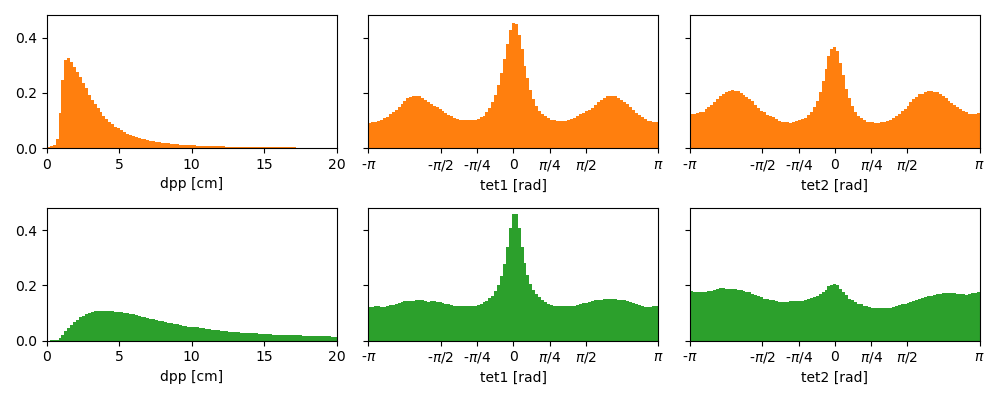

In [37]:
    
    
# ---- plot the histograms for each cluster_label ---- #

fig, axs = plt.subplots(nrows=k, ncols=3, figsize=(10,int(k*2)), sharey=True)

for clIdx in range(k):
    
    # parse info for this cluster
    cls_label = clIdx + 1
    cls_dpp_data, cls_tet1_data, cls_tet2_data = cluster_master_data_list[clIdx]
    
    # draw the histograms
    axs[clIdx,0].hist(cls_dpp_data, bins=hist_bins[0], density=True, label='dpp',
                      color='C{0}'.format(cls_label))
    axs[clIdx,1].hist(cls_tet1_data, bins=hist_bins[1], density=True, label='tet1',
                      color='C{0}'.format(cls_label))
    axs[clIdx,2].hist(cls_tet2_data, bins=hist_bins[2], density=True, label='tet2',
                      color='C{0}'.format(cls_label))
    
    # xticks 
    axs[clIdx,0].set_xticks([0, 5, 10, 15, 20, 25, 30])
    axs[clIdx,1].set_xticks([-np.pi, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, np.pi])
    axs[clIdx,2].set_xticks([-np.pi, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, np.pi])
    
    # xtick labels
    axs[clIdx,0].set_xticklabels([0, 5, 10, 15, 20, 25, 30])
    axs[clIdx,1].set_xticklabels([r'-$\pi$', r'-$\pi$/2', r'-$\pi$/4', '0',  r'$\pi$/4', r'$\pi$/2', r'$\pi$'])
    axs[clIdx,2].set_xticklabels([r'-$\pi$', r'-$\pi$/2', r'-$\pi$/4', '0',  r'$\pi$/4', r'$\pi$/2', r'$\pi$'])
    
    # xlims
    axs[clIdx,0].set_xlim(np.min(hist_bins[0]), np.max(hist_bins[0]))
    axs[clIdx,1].set_xlim(np.min(hist_bins[1]), np.max(hist_bins[1]))
    axs[clIdx,2].set_xlim(np.min(hist_bins[2]), np.max(hist_bins[2]))
    
    # xlabels
    axs[clIdx,0].set_xlabel('dpp [cm]')
    axs[clIdx,1].set_xlabel('tet1 [rad]')
    axs[clIdx,2].set_xlabel('tet2 [rad]')
    
    
fig.tight_layout()

In [176]:
# cluster label which denotes 'fight'
fight_cluster_label = 1

## save the cluster labels

In [179]:
clusterable_data_labels_path

'/media/liam/hd1/fighting_data/fight_detection_data/clusterable_data_labels.h5'

In [177]:
with h5py.File(clusterable_data_labels_path, 'w') as hf:
    hf.create_dataset('cluster_labels', data=cluster_labels)
    hf.create_dataset('fight_label_number', data=fight_cluster_label)

## save the other clustering params

In [183]:
cluster_params

{'dpp_bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 'theta_bins': array([-3.14159265, -2.82743339, -2.51327412, -2.19911486, -1.88495559,
        -1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,
         0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
         1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
         3.14159265]),
 'numStates': 8000,
 'window_size': 6000,
 'window_step': 100,
 'skip_size': 30,
 'g1_bins': array([-3.14159265, -2.82743339, -2.51327412, -2.19911486, -1.88495559,
        -1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,
         0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
         1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
         3.14159265]),
 'g2_bins': array([0.        , 0.15707963, 0.31415927, 0.4712389 , 0.62831853,
        0.78539816, 0.9424778 , 1.09955743, 1.25663706, 1.41371669,
   

In [187]:

#-----------  save all entries of cluster_parms to a h5 file. -----------#
with h5py.File(cluster_params_path, 'w') as hf:
    for key,val in cluster_params.items():
        hf.create_dataset(key, data=val)

In [ ]:
#-----------  load the cluster params dictionary -----------#

cluster_params_loaded = {}
with h5py.File(cluster_params_path, 'r') as hf:
    for param_key in hf.keys():
        
        try:
            param_value = hf[param_key][:]
        except:
            param_value = hf[param_key][()]

        cluster_params_loaded.update({param_key:param_value})
cluster_params_loaded

# Finding fight epochs using the clustering results

In [33]:
# k=2 #fight/nonfight
# cluster_labels = fcluster(Z, k, criterion='maxclust')

## find fight-bouts from the clustered data

In [26]:
expidx_and_decimated_wins_clusterable_data.shape

(5308, 3)

In [27]:
prob_vectors_clusterable_data.shape

(5308, 8000)

In [34]:
cluster_labels.shape

(5308,)

In [35]:
expidx_and_decimated_wins_clusterable_data

array([[     0,      0,   6000],
       [     0,   3000,   9000],
       [     0,   6000,  12000],
       ...,
       [    21, 711000, 717000],
       [    21, 714000, 720000],
       [    21, 717000, 723000]])

In [37]:
## ---- Find the window indices of the fight bouts in each experiment  ---- ##
# We will find contiguous regions of windows which were assigned the identity of fight windows

exp_fight_regions_indices = []

# --------------------------------------------------------#

t0 = time.perf_counter()

for expIdx,expName in enumerate(expNames):

    # get the rows corresponding to this experiment
    exp_row_indices = np.where(expidx_and_decimated_wins_clusterable_data[:,0] == expIdx)[0]

    # get the cluster labels for these rows  / windows
    exp_cluster_labels = cluster_labels[exp_row_indices]

    # find a binary timeseries of fight cluster membership
    fight_cluster_idx = 1
    fight_bin_tseries = np.zeros_like(exp_cluster_labels)
    fight_bin_tseries[exp_cluster_labels==fight_cluster_idx] = 1

    # get the fight regions - contiguous regions of fight cluster membership
    fight_regions_indices = contiguous_regions(fight_bin_tseries)

    # record
    exp_fight_regions_indices.append(fight_regions_indices)

tE = time.perf_counter()
print(tE-t0)


0.002022319007664919


In [ ]:

# if os.path.exists(savePath):
#     os.remove(savePath)

## Post-process the detected fight regions

In [38]:
# if fight regions are very close together, we should merge them
# if fight regions are very small, we should discard them

merge_gap_size_in_windows = 5
min_region_window_size = 5



# --------------------------------------------------------#
t0 = time.perf_counter()


## --- merge close by regions ---- ##

exp_fight_regions_indices_after_merge = []

for expIdx in range(len(expNames)):

    fight_regions_indices = exp_fight_regions_indices[expIdx]
    num_fight_regions = fight_regions_indices.shape[0]

    # prepare the list to hold the results
    fight_regions_indices_after_merge = []

    # start the variable which will update as we step through the list
    # this contains the start and stop window idxs for each region
    current_region_info = fight_regions_indices[0]

    # step through, merging as far into the future as we can
    for ii in range(num_fight_regions-1):

        # can i merge current and next bout?
        curr_region_end_idx = current_region_info[1]
        next_region_start_idx = fight_regions_indices[ii+1][0]
        num_indexs_between_regions = next_region_start_idx - curr_region_end_idx
        if num_indexs_between_regions < merge_gap_size_in_windows:
            do_merge_bouts = True
        else:
            do_merge_bouts = False

        if do_merge_bouts:
            current_region_start = current_region_info[0]
            next_region_end = fight_regions_indices[ii+1][1]
            current_region_info = np.array([current_region_start, next_region_end])
            continue
        else:
            # record what we have
            fight_regions_indices_after_merge.append(current_region_info)
            # move current info to next bout
            current_region_info = fight_regions_indices[ii+1]
            continue


    # record the last region
    fight_regions_indices_after_merge.append(current_region_info)
    
    # convert to array and record results for this experiment
    fight_regions_indices_after_merge = np.array(fight_regions_indices_after_merge)
    exp_fight_regions_indices_after_merge.append(fight_regions_indices_after_merge)

    
    
## --- remove small regions ---- ##

exp_fight_regions_indices_after_merge_and_minSizeThreshing = []

for expIdx in range(len(expNames)):

    regions = exp_fight_regions_indices_after_merge[expIdx]
    
    # get the region sizes
    region_sizes_in_windows = regions[:,1] - regions[:,0]
    
    # get the regIdxs to remove, and remove them
    remove_reg_idxs = np.where(region_sizes_in_windows < min_region_window_size)[0]
    threshed_regions = np.delete(regions, remove_reg_idxs, 0)
    
    # record
    exp_fight_regions_indices_after_merge_and_minSizeThreshing.append(threshed_regions)
    
    
tE = time.perf_counter()
print(tE-t0)

0.001215789932757616


In [39]:
exp_fight_regions_indices_after_merge_and_minSizeThreshing

[array([[128, 142],
        [194, 203],
        [214, 268]]),
 array([[ 91, 100],
        [128, 136],
        [164, 218],
        [233, 239]]),
 array([[ 10,  58],
        [100, 106]]),
 array([[110, 145]]),
 array([[ 95, 130]]),
 array([[149, 186]]),
 array([[72, 83]]),
 array([[ 30,  42],
        [168, 184]]),
 array([[ 60,  85],
        [ 91, 111],
        [117, 123]]),
 array([[214, 236]]),
 array([[ 6, 26]]),
 array([[71, 93]]),
 array([[ 47,  75],
        [ 87, 114],
        [119, 128]]),
 array([[231, 248]]),
 array([[ 2, 20]]),
 array([[  4,  61],
        [163, 171]]),
 array([[ 30,  50],
        [ 68,  94],
        [107, 120],
        [136, 168],
        [179, 213]]),
 array([[ 28,  41],
        [140, 145]]),
 array([[129, 185],
        [299, 310]]),
 array([[175, 190]]),
 array([[ 13,  56],
        [183, 195]]),
 array([[  0,   9],
        [ 34,  43],
        [ 58, 118],
        [129, 139],
        [188, 209]])]

## get the fight-boundaries in the form of an array of expIdxs and frame numbers

In [40]:
# --- find "fight_bout_ranges" ---- #

# An array over fight-bouts for all experiments,
# with rows containing the (expIdx, boutStartFrame, boutStopFrame, duration) for the bout

exps_fightBouts_startStops = []
for expIdx,expName in enumerate(expNames):
    
    # get the array of fight-bouts in window indices
    fight_region_window_idxs = exp_fight_regions_indices_after_merge_and_minSizeThreshing[expIdx]
    exp_numBouts =  fight_region_window_idxs.shape[0]
    
    # get the start-stop frames of all windows for this experiment
    exp_window_start_stop_frames = expidx_and_decimated_wins_clusterable_data[expidx_and_decimated_wins_clusterable_data[:,0]==expIdx][:,1:]
    
    # loop over the fight-bouts for this experiment, 
    # recording the frame ranges for all windows -> exp_bout_all_window_frames, (for debugging)
    # and recording the frames of the start and stop of the bout -> exp_bouts_startStops  (for main use)
    exp_bouts_all_window_frames = []
    exp_bouts_startStops = []
    for boutIdx in range(exp_numBouts):
        
        bout_all_window_frames = exp_window_start_stop_frames[fight_region_window_idxs[boutIdx,0]:fight_region_window_idxs[boutIdx,1]]
        exp_bouts_all_window_frames.append(bout_all_window_frames)
        
        bout_startStop_frames = np.array([np.mean(bout_all_window_frames[0]), np.mean(bout_all_window_frames[-1])])
        exp_bouts_startStops.append(bout_startStop_frames)
        
    # keep "exp_bouts_all_window_frames" as a list of arrays, one entry for each bout,
    # but we want "exp_bouts_startStops" as an array for ease of use (matches fight_region_window_idxs)
    exp_bouts_startStops = np.array(exp_bouts_startStops)
    
    # record results for this experiment
    exps_fightBouts_startStops.append(exp_bouts_startStops)
    
    
# finally, convert the list over experiments, into an array of (expIdx, boutStart, boutstop, duration) for each bout
exps_fight_info = []
for expIdx,expName in enumerate(expNames):
    exp_bouts_startStops = exps_fightBouts_startStops[expIdx]
    exp_bouts_startStops_with_expIdx = np.zeros((exp_bouts_startStops.shape[0], exp_bouts_startStops.shape[1] + 2))*np.NaN
    exp_bouts_startStops_with_expIdx[:,0] = expIdx
    exp_bouts_startStops_with_expIdx[:,1:3] = exp_bouts_startStops
    exp_bouts_startStops_with_expIdx[:,3] = exp_bouts_startStops_with_expIdx[:,2] - exp_bouts_startStops_with_expIdx[:,1]
    exps_fight_info.append(exp_bouts_startStops_with_expIdx)
exps_fight_info = np.concatenate(exps_fight_info).astype(int)

In [41]:
exps_fight_info.shape

(45, 4)

In [42]:
exps_fight_info

array([[     0, 387000, 426000,  39000],
       [     0, 585000, 609000,  24000],
       [     0, 645000, 804000, 159000],
       [     1, 276000, 300000,  24000],
       [     1, 387000, 408000,  21000],
       [     1, 495000, 654000, 159000],
       [     1, 702000, 717000,  15000],
       [     2,  33000, 174000, 141000],
       [     2, 303000, 318000,  15000],
       [     3, 333000, 435000, 102000],
       [     4, 288000, 390000, 102000],
       [     5, 450000, 558000, 108000],
       [     6, 219000, 249000,  30000],
       [     7,  93000, 126000,  33000],
       [     7, 507000, 552000,  45000],
       [     8, 183000, 255000,  72000],
       [     8, 276000, 333000,  57000],
       [     8, 354000, 369000,  15000],
       [     9, 645000, 708000,  63000],
       [    10,  21000,  78000,  57000],
       [    11, 216000, 279000,  63000],
       [    12, 144000, 225000,  81000],
       [    12, 264000, 342000,  78000],
       [    12, 360000, 384000,  24000],
       [    13, 

## refine the boundaries by clustering distributions around edges of fights

In [43]:
def create_padding_windows_before_bout_start_frame(start_frame, window_size, window_step, exp_nfs):
    ''' Given a frame index, create an array of sliding windows before the frame.
    '''
    # create the padding windows
    padding_starts = np.arange(start_frame-(window_size)+window_step, start_frame, window_step)
    padding_stops = padding_starts + window_size
    padding_windows = np.stack([padding_starts, padding_stops], axis=1)
    
    # remove any problematic windows
    bad_idxs = []
    good_idxs = []
    for winIdx in range(padding_windows.shape[0]):
        winF0, winFE = padding_windows[winIdx]
        if winF0 < 0:
            bad_idxs.append(winIdx)
        elif winFE < 0:
            bad_idxs.append(winIdx)
        elif winFE >= exp_nfs:
            bad_idxs.append(winIdx)
        else:
            good_idxs.append(winIdx)
    padding_windows_parsed = []
    for idx in good_idxs:
        padding_windows_parsed.append(padding_windows[idx])
    padding_windows_parsed = np.array(padding_windows_parsed)
    
    # finally, return a simply padding without to avoid problems if empty
    if padding_windows_parsed.shape[0] == 0:
        padding_windows_parsed = np.array([start_frame, start_frame+window_size]).reshape(1,2)
            
    return padding_windows_parsed.astype(int)


    
def create_padding_windows_before_bout_stop_frame(stop_frame, window_size, window_step, exp_nfs):
    ''' Given a frame index, create an array of sliding windows after the frame.
    '''
    # create the padding windows
    padding_starts = np.arange(stop_frame-window_size+window_step, stop_frame, window_step)
    padding_stops = padding_starts + window_size
    padding_windows = np.stack([padding_starts, padding_stops], axis=1)
    
    # remove any problematic windows
    bad_idxs = []
    good_idxs = []
    for winIdx in range(padding_windows.shape[0]):
        winF0, winFE = padding_windows[winIdx]
        if winF0 < 0:
            bad_idxs.append(winIdx)
        elif winFE < 0:
            bad_idxs.append(winIdx)
        elif winFE >= exp_nfs:
            bad_idxs.append(winIdx)
        else:
            good_idxs.append(winIdx)
    padding_windows_parsed = []
    for idx in good_idxs:
        padding_windows_parsed.append(padding_windows[idx])
    padding_windows_parsed = np.array(padding_windows_parsed)
            
    return padding_windows_parsed.astype(int)



def create_sliding_windows_around_detected_bout(bout_detected_start_frame, bout_detected_end_frame, exp_nfs, window_size, window_step):
    ''' Given the start and end frame of a fight bout detected by the clustering (decimated),
        create some sliding windows either side of the fight, to probe if the bout can be 
        extended futher backwards of forwards in time (to refine the start and stop frames).
    '''
    bout_start_padding_windows = create_padding_windows_before_bout_start_frame(bout_detected_start_frame, 
                                                                                window_size, 
                                                                                window_step, 
                                                                                exp_nfs)
    bout_stop_padding_windows = create_padding_windows_before_bout_stop_frame(bout_detected_end_frame, 
                                                                              window_size, 
                                                                              window_step, 
                                                                              exp_nfs)

    bout_padding_windows = np.concatenate([bout_start_padding_windows, bout_stop_padding_windows])
    return bout_padding_windows

In [372]:
t0 = time.perf_counter()


refined_exps_fight_info = []

# --------------------------------------------------#

numBouts = exps_fight_info.shape[0]
#for boutIdx in range(1):
for boutIdx in range(numBouts):
    # parse the info for this bout
    expIdx, old_bout_startFrame, old_bout_stopFrame, old_bout_duration = exps_fight_info[boutIdx]
    exp_nfs = expNumFrames[expIdx]
    
    
    # create padding windows around the bout
    # We will identify boundaries down to a resolution of 2 windows steps (2s)
    bout_padding_windows = create_sliding_windows_around_detected_bout(old_bout_startFrame, 
                                                                       old_bout_stopFrame, 
                                                                       exp_nfs, 
                                                                       window_size,
                                                                       window_step)
    bout_padding_windows = bout_padding_windows[::2]
    
    
    
    
    # get the prob vecs for each padding window, only using nonNaN windows
    g1_arr, g2_arr = symmetrize_tet1_tet2(exp_tetWs[expIdx], exp_tetLs[expIdx])
    prob_vectors_for_bout_padding_windows = get_1D_prob_vectors_from_dpp_g1_g2_in_timeWins(exp_dpps[expIdx], 
                                                                                           g1_arr, g2_arr,
                                                                                           cluster_params['dpp_bins'],
                                                                                           cluster_params['g1_bins'],
                                                                                           cluster_params['g2_bins'],
                                                                                           bout_padding_windows)
    prob_vectors_for_bout_padding_windows_nanless = prob_vectors_for_bout_padding_windows[ np.where(~np.isnan(prob_vectors_for_bout_padding_windows).any(axis=1))[0] ]
    bout_padding_windows_nanless = bout_padding_windows[ np.where(~np.isnan(bout_padding_windows).any(axis=1))[0] ]
    
    
    
    #  compute the distance for each prob vec to all clustered data 
    prob_vectors_for_bout_padding_windows_nanless_distances = np.zeros((prob_vectors_for_bout_padding_windows_nanless.shape[0],
                                                                        prob_vectors_clusterable_data.shape[0]))
    for pad_vec_idx in range(prob_vectors_for_bout_padding_windows_nanless.shape[0]):
        for clust_vec_idx in range(prob_vectors_clusterable_data.shape[0]):
            pad_vec = prob_vectors_for_bout_padding_windows_nanless[pad_vec_idx]
            clust_vec = prob_vectors_clusterable_data[clust_vec_idx]
            pad_clust_dist = distance.jensenshannon(pad_vec, clust_vec, base=2)
            prob_vectors_for_bout_padding_windows_nanless_distances[pad_vec_idx, clust_vec_idx] = pad_clust_dist
            
            
    #  get the new boundaries using the nearest neighbors 
    #  the first window labelled fight is the new start, and the last window labelled fight is new stop
    pad_vec_NN_idxs = np.argmin(prob_vectors_for_bout_padding_windows_nanless_distances, axis=1)
    pad_vec_cluster_labels = cluster_labels[pad_vec_NN_idxs]

    first_fight_index = np.where(pad_vec_cluster_labels==fight_cluster_idx)[0][0]
    last_fight_index = np.where(pad_vec_cluster_labels==fight_cluster_idx)[0][-1]

    first_win = bout_padding_windows_nanless[first_fight_index]
    last_win = bout_padding_windows_nanless[last_fight_index]

    bout_start = np.mean(first_win)
    bout_stop = np.mean(last_win)
    bout_duration = bout_stop - bout_start
    expIdx_bout_start_stop_duration = np.array([expIdx, bout_start, bout_stop, bout_duration]).astype(int)  
    
    # record the results for this bout
    refined_exps_fight_info.append(expIdx_bout_start_stop_duration)
    
    
refined_exps_fight_info = np.stack(refined_exps_fight_info, axis=0)
    
tE = time.perf_counter()
print(tE-t0, ' s')

/tmp/ipykernel_718118/3243086601.py:28: RuntimeWarning: invalid value encountered in remainder
  beta = np.mod(alpha, 2*np.pi)
/tmp/ipykernel_718118/3243086601.py:49: RuntimeWarning: invalid value encountered in remainder
  beta = np.mod(alpha, 2*np.pi)


3103.508852800005  s


In [54]:
refined_exps_fight_info

NameError: name 'refined_exps_fight_info' is not defined

In [394]:
exps_fight_info

array([[     0, 387000, 426000,  39000],
       [     0, 585000, 609000,  24000],
       [     0, 645000, 804000, 159000],
       [     1, 276000, 300000,  24000],
       [     1, 387000, 408000,  21000],
       [     1, 495000, 654000, 159000],
       [     1, 702000, 717000,  15000],
       [     2,  33000, 174000, 141000],
       [     2, 303000, 318000,  15000],
       [     3, 333000, 435000, 102000],
       [     4, 288000, 390000, 102000],
       [     5, 450000, 558000, 108000],
       [     6, 219000, 249000,  30000],
       [     7,  93000, 126000,  33000],
       [     7, 507000, 552000,  45000],
       [     8, 183000, 255000,  72000],
       [     8, 276000, 333000,  57000],
       [     8, 354000, 369000,  15000],
       [     9, 645000, 708000,  63000],
       [    10,  21000,  78000,  57000],
       [    11, 216000, 279000,  63000],
       [    12, 144000, 225000,  81000],
       [    12, 264000, 342000,  78000],
       [    12, 360000, 384000,  24000],
       [    13, 

## save

In [ ]:
with h5py.File(fightBouts_info_path, 'w') as hf:
    hf.create_dataset('exps_fight_info', data=exps_fight_info)
    hf.create_dataset('refined_exps_fight_info', data=refined_exps_fight_info)
    


# ----------------------------------#

# Creating subsets of fight-bouts used for other situations.

## make a dataframe from the fight detector results

In [ ]:
# --------   Make the dataFrame from the refined fight-boundaries  ------------------------#

with h5py.File(fightBouts_info_path, 'r') as hf:
    exps_fight_info = hf['refined_exps_fight_info'][:]
    
# make a dataframe for the fight info
fight_cols = ['expIdxs', 'startIdx', 'stopIdx', 'durations']
fight_bout_df = pd.DataFrame(data=exps_fight_info, columns=fight_cols)

# make a column showing if the experiment ended with a conclusive winner and loser
ends_conclusive_arr = []
df_expIdxs_col = fight_bout_df['expIdxs'].values
for ii, expIdx in enumerate(df_expIdxs_col):
    ends_conclusive_arr.append(conclusive_winner_loser[expIdx])
ends_conclusive_arr = np.array(ends_conclusive_arr)
fight_bout_df['conclusive_winner'] = ends_conclusive_arr

# make a column showing if the experiment had an existing dominance relationship
existing_dominance_arr = []
df_expIdxs_col = fight_bout_df['expIdxs'].values
for ii, expIdx in enumerate(df_expIdxs_col):
    existing_dominance_arr.append(already_established_dominance[expIdx])
existing_dominance_arr = np.array(existing_dominance_arr)
fight_bout_df['existing_dominance'] = existing_dominance_arr

# make a column to show how close each bout is to the end of the experiment
bouts_frames_to_end = []
df_bout_stop_idxs_col = fight_bout_df['stopIdx'].values
df_expIdxs_col = fight_bout_df['expIdxs'].values
for rowIdx,expIdx in enumerate(df_expIdxs_col):
    #print(rowIdx, expIdx)
    row_nfs = smooth_trajectories[expIdx].shape[0]
    row_frame_to_end = row_nfs - df_bout_stop_idxs_col[rowIdx]
    bouts_frames_to_end.append(row_frame_to_end)
bouts_frames_to_end = np.array(bouts_frames_to_end)
fight_bout_df['frames_post_bout'] = bouts_frames_to_end

In [115]:
fight_bout_df

,expIdxs,startIdx,stopIdx,durations,conclusive_winner,existing_dominance,frames_post_bout
0,0,385500,427400,41900,1,0,544356
1,0,583500,610400,26900,1,0,361356
2,0,643500,805400,161900,1,0,166356
3,1,274500,301400,26900,1,0,468448
4,1,385700,409400,23700,1,0,360448
5,1,493700,655400,161700,1,0,114448
6,1,700700,718600,17900,1,0,51248
7,2,31500,175400,143900,1,0,326543
8,2,301300,319600,18300,1,0,182343
9,3,331300,436400,105100,1,0,80600


## figure 7 boundaries

For figure 7, we don't want to use all of the detected fight-bouts. <br>
We want to exclude,  <br>
(1) the two experiments that did not end conclusively.  <br>
(2) the two experiments that had the dominance relationship already strongley established.  <br>
(3) bouts that are shorter than 7 mins (to avoid the starts and ends of bouts overlapping in figure 7). <br>

In [132]:
# ---------    Apply criteria to fight bouts  ----------------------------------------#
# make a version of the fight-bout dataframe for triggering on starts/stops

# 7 mins, for 2 three-minute segments wihoutout overlap, plus 6000 frames (i.e. 2 30sec frame segments for window overlap past 3 mins)
duration_thresh = 36000 + 6000  

# selecting rows based on ending with clear winner/loser, and longer than frame gap
fight_bout_df_for_fight_triggers = fight_bout_df.loc[(fight_bout_df['conclusive_winner'] == 1) &
                                                          (fight_bout_df['existing_dominance'] == 0) &
                                                          (fight_bout_df['durations'] >= (duration_thresh))
                                                         ]

In [128]:
fight_bout_df_for_fight_triggers

,expIdxs,startIdx,stopIdx,durations,conclusive_winner,existing_dominance,frames_post_bout
2,0,643500,805400,161900,1,0,166356
5,1,493700,655400,161700,1,0,114448
7,2,31500,175400,143900,1,0,326543
9,3,331300,436400,105100,1,0,80600
11,5,448500,559400,110900,1,0,170719
14,7,505500,553400,47900,1,0,47826
15,8,181500,256200,74700,1,0,281680
16,8,274700,334400,59700,1,0,203480
19,10,19700,79400,59700,1,0,481610
20,11,214900,280400,65500,1,0,276028


In [119]:
fight_bout_info = fight_bout_df_for_fight_end_triggered[['expIdxs', 'startIdx', 'stopIdx', 'durations']].values
fight_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

In [121]:
fight_bout_info.shape

(18, 4)

There are 4 experiments with multilple fight-bouts in this set. <br>
expIdx=8,12 <br>
<br>
We want to make sure that none are closer than 3 mins (18,000 frames)

In [122]:
# check how close fight-bouts are to each other
print(expNames[8])
fight_bout_info[fight_bout_info[:,0]==8]

FishTank20200218_153008


array([[     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700]])

In [123]:
274700 - 256200

18500

In [124]:
# check how close fight-bouts are to each other
print(expNames[12])
fight_bout_info[fight_bout_info[:,0]==12]

FishTank20200331_162136


array([[    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900]])

In [125]:
262500 - 226400

36100

In [130]:
fight_bout_info.shape

(18, 4)

In [129]:
fight_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

In [131]:
# save
with h5py.File(fightBouts_info_path, 'a') as hf:
    hf.create_dataset('fight_bout_info', data=fight_bout_info)

## create a version of fight_bout_info without the size threshold

In [133]:
# selecting rows based on ending with clear winner/loser, and longer than frame gap
fight_bout_df_for_fight_triggers_noDurThresh = fight_bout_df.loc[(fight_bout_df['conclusive_winner'] == 1) &
                                                                  (fight_bout_df['existing_dominance'] == 0)
                                                                 ]

fight_bout_df_for_fight_triggers_noDurThresh

,expIdxs,startIdx,stopIdx,durations,conclusive_winner,existing_dominance,frames_post_bout
0,0,385500,427400,41900,1,0,544356
1,0,583500,610400,26900,1,0,361356
2,0,643500,805400,161900,1,0,166356
3,1,274500,301400,26900,1,0,468448
4,1,385700,409400,23700,1,0,360448
5,1,493700,655400,161700,1,0,114448
6,1,700700,718600,17900,1,0,51248
7,2,31500,175400,143900,1,0,326543
8,2,301300,319600,18300,1,0,182343
9,3,331300,436400,105100,1,0,80600


In [134]:
fight_bout_info_noDurThresh = fight_bout_df_for_fight_triggers_noDurThresh[['expIdxs', 'startIdx', 'stopIdx', 'durations']].values
fight_bout_info_noDurThresh

array([[     0, 385500, 427400,  41900],
       [     0, 583500, 610400,  26900],
       [     0, 643500, 805400, 161900],
       [     1, 274500, 301400,  26900],
       [     1, 385700, 409400,  23700],
       [     1, 493700, 655400, 161700],
       [     1, 700700, 718600,  17900],
       [     2,  31500, 175400, 143900],
       [     2, 301300, 319600,  18300],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     6, 217700, 250400,  32700],
       [     7,  91500, 127400,  35900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [     8, 352500, 370400,  17900],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    12, 358500, 385400,  26900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15, 

In [135]:
fight_bout_info_noDurThresh.shape

(33, 4)

In [136]:
# save
with h5py.File(fightBouts_info_path, 'a') as hf:
    hf.create_dataset('fight_bout_info_noDurThresh', data=fight_bout_info_noDurThresh)

# --------------------------------#

# Loading the fight-boundaries

In [137]:
with h5py.File(fightBouts_info_path, 'r') as hf:
    exps_fight_info = hf['exps_fight_info'][:]
    refined_exps_fight_info = hf['refined_exps_fight_info'][:]
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

In [138]:
# the fight-bouts detected at 30s resolution
exps_fight_info.shape

(45, 4)

In [139]:
# the fight-bouts detected with refined edges (down to 2s)
refined_exps_fight_info.shape

(45, 4)

In [140]:
# the main set of fight-bouts used in this paper
fight_bout_info.shape

(18, 4)

In [141]:
# the main set of fight-bouts used in this paper, but without a duration threshold on bouts
fight_bout_info_noDurThresh.shape

(33, 4)

# Plot the distribution of fight-bout sizes (SI fig 11)

To plot the distribution of fight-bout sizes, we will use the fight_bout_info_noDurThresh results

In [142]:
fight_bout_info_noDurThresh

array([[     0, 385500, 427400,  41900],
       [     0, 583500, 610400,  26900],
       [     0, 643500, 805400, 161900],
       [     1, 274500, 301400,  26900],
       [     1, 385700, 409400,  23700],
       [     1, 493700, 655400, 161700],
       [     1, 700700, 718600,  17900],
       [     2,  31500, 175400, 143900],
       [     2, 301300, 319600,  18300],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     6, 217700, 250400,  32700],
       [     7,  91500, 127400,  35900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [     8, 352500, 370400,  17900],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    12, 358500, 385400,  26900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15, 

In [143]:
durations_frames = fight_bout_info_noDurThresh[:, 3]
durations_mins = durations_frames / (6000)

In [144]:
durations_mins

array([ 6.98333333,  4.48333333, 26.98333333,  4.48333333,  3.95      ,
       26.95      ,  2.98333333, 23.98333333,  3.05      , 17.51666667,
       18.48333333,  5.45      ,  5.98333333,  7.98333333, 12.45      ,
        9.95      ,  2.98333333,  9.95      , 10.91666667, 13.98333333,
       13.48333333,  4.48333333,  8.51666667,  9.01666667, 28.48333333,
        4.01666667,  6.48333333,  2.51666667, 27.95      ,  5.45      ,
        7.41666667, 21.45      ,  5.95      ])

In [145]:
np.mean(durations_mins)

11.052020202020202

In [146]:
np.max(durations_mins)

28.483333333333334

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
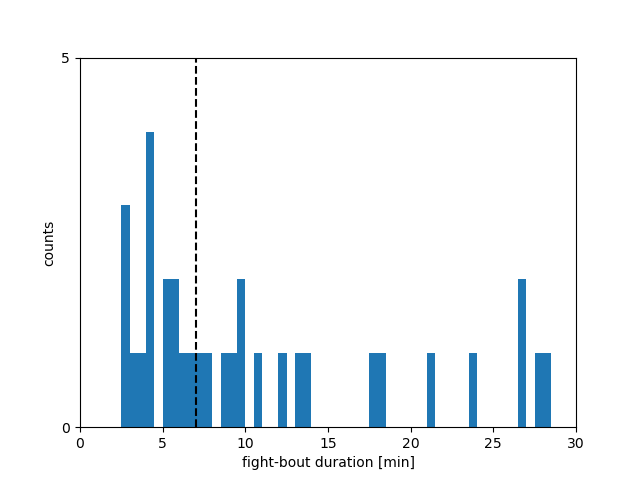

In [158]:
fig, axs = plt.subplots()
ax = axs

y_tick_max = 5
hbins = np.arange(0, 30, 0.5)
ax.hist(durations_mins, bins=hbins);
ax.set_xlim(0, np.max(hbins))
ax.set_ylabel('counts')
ax.set_xlabel('fight-bout duration [min]')
ax.set_yticks([0, y_tick_max])
ax.set_xticks([0,5,10,15,20,25,30])
ax.set_ylim([0, y_tick_max])
ax.axvline(7, color='black', linestyle='--')  # draw the size threshold line

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
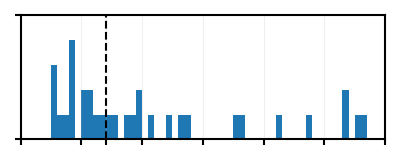

In [162]:
fig, axs = plt.subplots(figsize=(4,1.6))
ax = axs

y_tick_max = 5
hbins = np.arange(0, 30, 0.5)
ax.hist(durations_mins, bins=hbins);
ax.set_xlim(0, np.max(hbins))
ax.set_ylabel('counts')
ax.set_xlabel('fight-bout duration [min]')
ax.set_yticks([0, y_tick_max])
ax.set_xticks([0,5,7,10,15,20,25,30])
ax.set_ylim([0, y_tick_max])
ax.axvline(7, color='black', linestyle='--')  # draw the size threshold line
# -------------------------------------------#

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5, length=4)
ax.yaxis.set_tick_params(width=1.5, length=4)
ax.grid(alpha=0.2)
fig.tight_layout()
fig.savefig('/home/liam/temp/image_transfer/SI_fight_bout_durations.png', dpi=300, transparent=True)